# Clustering Routine

This Jupyter Notebook can be ran after the initial crawling with the *crawl.py* python script to categorize a big number of news articles by their topics. The duration of the Jupyter Notebook processing time may vary depending on your dataset size. You can estimate at least a few hours for datasets bigger than 50 000 articles.

# Routine Of The Jupyter Notebook

This algorithm can be structured into the following main components:

1. Load crawled dataset from the folder *./crawl_json/*.
2. Preprocessing.
3. Visualize the data with wordclouds.
4. LDA Clustering. Find the optimal amount of clusters with the coherence score.
5. Visualize the optimal topic clusters with LDAvis.
6. Sort all documents into a directory *./clustered_json/* to represent their cluster topics.


# Open Data From JSON
First we have to load our previously cralwed dataset into memory.

In [1]:
import pandas as pd
import os
import glob

In [2]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...


# Amount of articles that will be processed:

In [3]:
amount_of_articles = len(df["maintext"])
print(f"Amount of articles: {amount_of_articles}")

Amount of articles: 268122


# Preprocessing 

We will now continue with preparing the data for the actual clustering. Therefore we are lemmatizing all strings and removing all words that aren't nouns.

In [4]:
import re

In [5]:
df['id'] = df.index
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2


In [6]:
# Remove punctuation
df['maintext_prepro'] = \
df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))
# To lowercase
df['maintext_prepro'] = \
df['maintext_prepro'].map(lambda x: x.lower())

In [7]:
import nltk
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns = []

stemmer = WordNetLemmatizer()

estimated_minutes = amount_of_articles * 0.000217

print(f'Tokenizing all articles. This may take a while. (Estimate: ~{ round(estimated_minutes, 2) } minutes)')
df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)
print("Finished tokenizing all articles. Continue with lemmatization & noun extraction.")


Tokenizing all articles. This may take a while. (Estimate: ~58.18 minutes)
Finished tokenizing all articles. Continue with lemmatization & noun extraction.


In [9]:
print("Lemmatization & noun extraction is running...")
for element in tqdm(df["tokenized_words"]):
	nouns.append(" ".join([stemmer.lemmatize(word) for (word, pos) in nltk.pos_tag(element) if is_noun(pos) and len(word) > 2]))    # joined as a single string per article

print("Finished lemmatization & noun extraction.")
df["maintext_nouns"] = nouns

Lemmatization & noun extraction is running...


100%|██████████| 268122/268122 [4:35:16<00:00, 16.23it/s]


Finished lemmatization & noun extraction.


In [10]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...


# Word Cloud

The following word clouds will give you a general idea about how each step in preprocessing improves the quality of the dataset for our use case. The bigger a word is shown, the more frequent is its existence in our dataset. 

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=400, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Word Cloud All Words

This word cloud includes all words of the articles without major filtering.

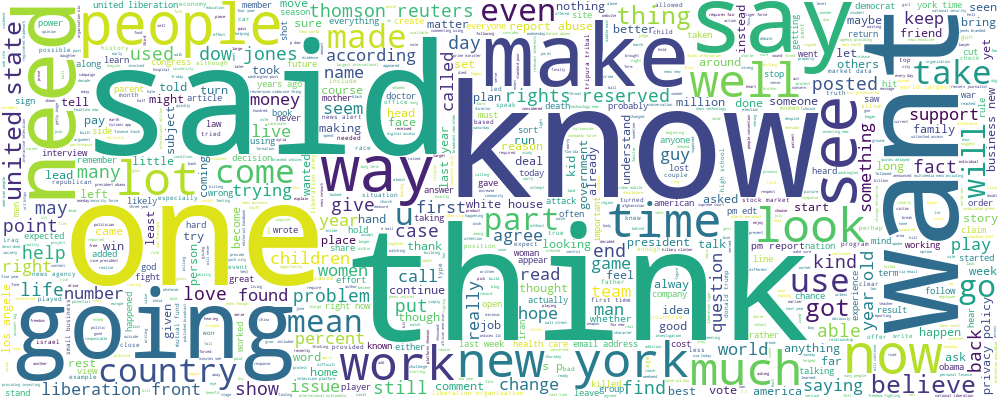

In [12]:
all_articles_string = ','.join(list(df['maintext_prepro'].values))
wordcloud.generate(all_articles_string)

wordcloud.to_image()

# Word Cloud Only Nouns

This word cloud shows you only the nouns of the acticles.

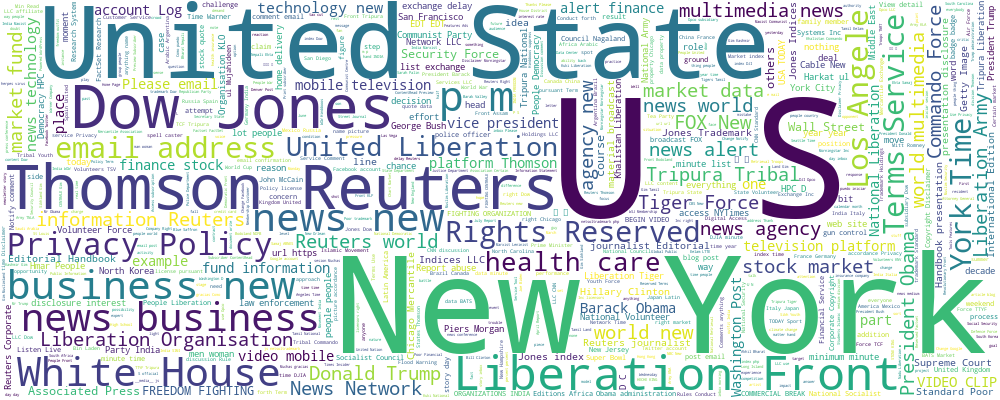

In [13]:
all_articles_nouns = ','.join(list(df['maintext_nouns'].values))
wordcloud.generate(all_articles_nouns)

wordcloud.to_image()

# Prepare data for LDA analysis

We will continue preparing our data for the LDA clustering by removing predefined stopwords (extended by *./stopwords.json*) and filtering out unwanted characters.

In [14]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
stop_words = stopwords.words('english')

with open("stopwords.json") as jsonFile:
    jsonStopwords = json.load(jsonFile)

#extend stopwords if desired
stop_words.extend(jsonStopwords)  


In [16]:
#Tokenize Text
def sentence_to_words(sentences):
    for sent in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sent, deacc=True))

In [17]:
#Remove Stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if (word not in stop_words)] for doc in texts]    #filtering

In [18]:
#Remove non alphanumeric words
def remove_non_alphanumeric(texts):
    return [[word for word in list if word.isalnum()] for list in texts]

In [19]:
#remove words that are not written in ASCII
def remove_non_ASCII(lists):
    for list in lists:
        for i, string in enumerate(list):
            if string.isascii():
                continue
            else:
                list.pop(i)
    return lists

In [20]:
maintext_data = df["maintext_nouns"].values.tolist()
df["maintext_ready"] = list(sentence_to_words(maintext_data))

maintext_ready = remove_stopwords(df["maintext_ready"].tolist())
maintext_ready = remove_non_ASCII(maintext_ready)
df["maintext_ready"]  = maintext_ready

In [21]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[global, public, square, show, fareed, take, g..."


# Wordcloud of the ready-to-cluster articles

This is the word cloud of the dataset which we will actually apply out LDA clustering on.

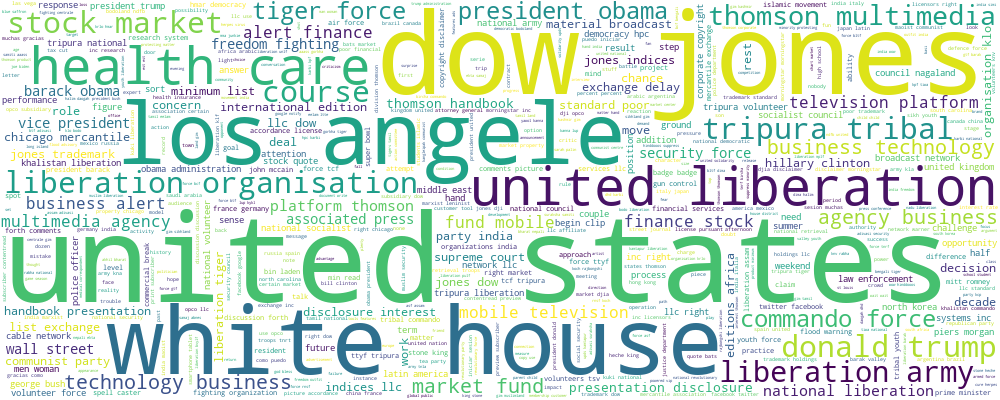

In [22]:
ready_wordlist = []
for element in df["maintext_ready"]:
    ready_wordlist.append(','.join(list(element)))

all_articles_ready = ','.join(ready_wordlist)
wordcloud.generate(all_articles_ready)

wordcloud.to_image()

# Create the Corpus

Creating a corpus is needed to have data that is understandable to gensim. This will be given to the LDA algorithm to perform the clustering.

In [23]:
import gensim.corpora as corpora

In [24]:
data = df["maintext_ready"].tolist()

word_dictionary = corpora.Dictionary(data)

corpus = [word_dictionary.doc2bow(text) for text in data]   #create the corpus

df["corpus"] = corpus

In [25]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,...","[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo...","[(24, 1), (25, 1), (26, 1), (27, 7), (28, 1), ..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[global, public, square, show, fareed, take, g...","[(3, 1), (24, 5), (54, 1), (82, 1), (95, 1), (..."


# Build a LDA model & calculate Coherence Score

The following code is going through a prefined range of topic amounts to check which clustering approach suits the dataset best. Each iteration inlcludes the clustering of all articles and the calculation of the coherence score. Once a certain coherence is reached, the algorithm continues with taking the best possible clusters.
We implement this break within the algorithm to avoid unneccasary splitting of clusters.

In [26]:
from pprint import pprint   #pretty printing
from gensim.models import CoherenceModel

In [27]:
topic_amount_start = 10     #specify where to start generating clusters
topic_amount_end = 50      #specify the maximum amount of clusters (will need more RAM during calculations)
iteration_interval = 1      #the interval in which coherences and lda models should be calculated (for example: iteration_interval = 5 => 10,15,20,25,... clusters). For best results choose 1 (but it will take longer then)
desired_coherence = 0.6     #the minimum coherence. if set too high, the algorithm will continue with the clusters with highest coherence score between topic_amount_start and topic_amound_end

The following snipped is responsible for the actual LDA clustering. It will determine the coherence score each iteration and choose the best possible clusters based on the coherence score.
If `desired_coherence` is met, the algorithm will break to avoid unneccasary high amounts of clusters.

In [28]:
amount_of_topics = 0
best_coherence = 0
best_lda_model = 0

coherences = []
lda_models = []

print(f"Calculating the optimal amount of clusters inbetween {topic_amount_start} and {topic_amount_end}.")

#Find the best possible coherence value inbetween the given min and max amount of articles. Continue with the best lda model found.
for amount_of_topics in range(topic_amount_start, topic_amount_end, iteration_interval):   
    lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = word_dictionary, num_topics = amount_of_topics, alpha=0.1, eta=0.01)   #build the LDA model

    cm = CoherenceModel(model=lda_model, texts=df["maintext_ready"].tolist(), dictionary=word_dictionary, coherence='c_v')     #calculate coherence
    coherence = cm.get_coherence()
    print(f"Coherence with {amount_of_topics} topics: ", coherence)

    coherences.append(coherence)
    lda_models.append(lda_model)

    if (coherence > desired_coherence):
        best_coherence = coherence
        best_lda_model = lda_model
        print("Reached the desired coherence score!")
        break;      # desired coherence score met



Calculating the optimal amount of clusters inbetween 10 and 50.
Coherence with 10 topics:  0.4458292678463738
Coherence with 11 topics:  0.50442426616625
Coherence with 12 topics:  0.5035018555433707
Coherence with 13 topics:  0.525525066766815
Coherence with 14 topics:  0.48837059863273796
Coherence with 15 topics:  0.5129135019310569
Coherence with 16 topics:  0.5805812451241403
Coherence with 17 topics:  0.5072479898060319
Coherence with 18 topics:  0.5437338960158993
Coherence with 19 topics:  0.5749448889318809
Coherence with 20 topics:  0.48603093123355484
Coherence with 21 topics:  0.5280892370820444
Coherence with 22 topics:  0.4950715465784528
Coherence with 23 topics:  0.4882736114227831
Coherence with 24 topics:  0.506675807937596
Coherence with 25 topics:  0.4932382880903839
Coherence with 26 topics:  0.4582773539433346
Coherence with 27 topics:  0.5068252336999045
Coherence with 28 topics:  0.4730427327870571
Coherence with 29 topics:  0.523066633004768
Coherence with 30 t

In [29]:
#Determine the best coherence of all if the desired_coherence wasnt matched
if (best_coherence == 0):
    print("Desired coherence not reached. Please adjust the desired_coherence paramter to a more realistic value. Continuing with the best possible coherence.")
    max_coherence = max(coherences)
    max_index = coherences.index(max_coherence)
    print(max_index)
    best_lda_model = lda_models[max_index]

amount_of_topics = len(best_lda_model.get_topics())
print("Best coherence: " + str(max_coherence) + ", Amount of clusters: " + str(amount_of_topics))

Desired coherence not reached. Please adjust the desired_coherence paramter to a more realistic value. Continuing with the best possible coherence.
6
Best coherence: 0.5805812451241403, Amount of clusters: 16


In [30]:
print(len(lda_model[corpus]))

268122


In [31]:
import matplotlib.pyplot as plt

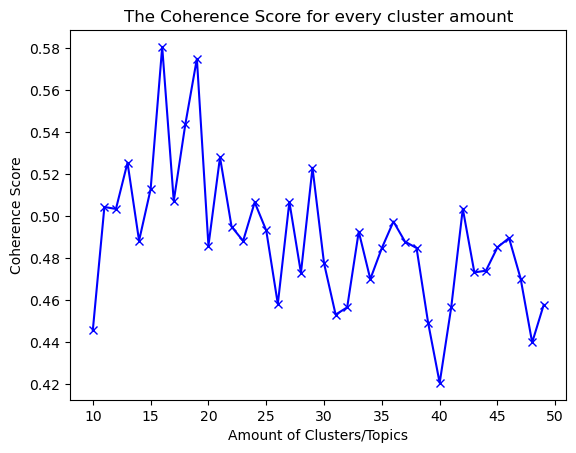

In [32]:
# A graph about how the coherence changes depending on the amount of clusters
plt.plot(range(topic_amount_start, topic_amount_end, iteration_interval), coherences, 'bx-')
plt.xlabel('Amount of Clusters/Topics')
plt.ylabel('Coherence Score')
plt.title('The Coherence Score for every cluster amount')
plt.show()

# Displaying the LDA model

This is the built LDA model. The first number represents the cluster ID. The other part shows you the propablity of words in the specific topic.

In [33]:
pprint(best_lda_model.print_topics())
articles_lda = best_lda_model[corpus]

[(0,
  '0.014*"president" + 0.012*"king" + 0.009*"trump" + 0.008*"stone" + '
  '0.006*"heche" + 0.005*"government" + 0.004*"house" + 0.004*"right" + '
  '0.003*"degeneres" + 0.003*"official"'),
 (1,
  '0.006*"city" + 0.004*"loan" + 0.004*"business" + 0.003*"house" + '
  '0.003*"music" + 0.003*"price" + 0.003*"president" + 0.003*"united" + '
  '0.002*"group" + 0.002*"oil"'),
 (2,
  '0.015*"india" + 0.014*"thomson" + 0.009*"business" + 0.006*"united" + '
  '0.006*"china" + 0.006*"international" + 0.005*"africa" + 0.005*"television" '
  '+ 0.004*"alert" + 0.004*"agency"'),
 (3,
  '0.009*"police" + 0.006*"house" + 0.005*"court" + 0.004*"city" + 0.004*"law" '
  '+ 0.004*"district" + 0.004*"officer" + 0.003*"right" + 0.003*"gun" + '
  '0.003*"death"'),
 (4,
  '0.013*"obama" + 0.007*"president" + 0.006*"health" + 0.006*"tax" + '
  '0.006*"bill" + 0.006*"house" + 0.005*"care" + 0.005*"law" + 0.004*"party" + '
  '0.004*"government"'),
 (5,
  '0.006*"business" + 0.006*"badge" + 0.006*"market" + 

# Visualize the LDA model

This visualization is interactable and helps you identifying the quality of the LDA clustering by hand.

In [34]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

In [35]:
LDAvis_data_filepath = os.path.join('./lda_results/ldavis_data_'+str(amount_of_topics)+'topics')

LDAvis_prepared = pyLDAvis.gensim_models.prepare(best_lda_model, corpus, word_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

#load pre-prepared pyLDAvis data
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_data = pickle.load(f)
pyLDAvis.save_html(LDAvis_data, './lda_results/ldavis_data_'+ str(amount_of_topics) +'topics.html')
LDAvis_data #show the data

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.006953  0.038973       1        1  12.573802
8      0.046673  0.001295       2        1  12.351862
10     0.035343  0.010795       3        1  10.044407
6      0.032496 -0.024319       4        1   7.776341
3      0.015627  0.033892       5        1   7.662686
9      0.005845  0.039279       6        1   6.643183
4     -0.006130  0.062373       7        1   6.523200
1      0.004828 -0.025381       8        1   5.854106
0      0.001182  0.022466       9        1   5.602970
14    -0.199724  0.031791      10        1   4.554993
13     0.011070  0.018559      11        1   4.293440
2     -0.039723 -0.154732      12        1   4.036940
15    -0.024328 -0.005630      13        1   3.754909
11     0.056254  0.013995      14        1   3.513267
12     0.042691 -0.013767      15        1   2.895674
5      0.010943 -0.049589      16        1   1.918219, topic_info=             Term           Freq          Total Category  logprob  loglift
1261        force  187098.000000  187098.000000  Default  30.0000  30.0000
810    liberation  114987.000000  114987.000000  Default  29.0000  29.0000
65029     tripura   92594.000000   92594.000000  Default  28.0000  28.0000
279         india  125620.000000  125620.000000  Default  27.0000  27.0000
858      national  152493.000000  152493.000000  Default  26.0000  26.0000
...           ...            ...            ...      ...      ...      ...
97       interest    2976.488988   85336.661424  Topic16  -6.3251   0.5979
497          work    3151.807761  151560.339647  Topic16  -6.2679   0.0808
479         party    3163.891605  160802.246465  Topic16  -6.2641   0.0254
294           law    3050.293915  179199.219184  Topic16  -6.3006  -0.1195
1003       united    3030.872574  188482.678720  Topic16  -6.3070  -0.1764

[1773 rows x 6 columns], token_table=        Topic      Freq        Term
term                               
39090      11  0.970634         aao
39090      12  0.038825         aao
114993      1  0.009303   abbeville
114993      3  0.009303   abbeville
114993      4  0.009303   abbeville
...       ...       ...         ...
35394       2  0.943361    インタラクティフ
35395       2  0.988923  テクノロシーニュース
35398       1  0.027643         フロク
35398       2  0.967495         フロク
35399       2  0.960051   マーケットニュース

[14547 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 11, 7, 4, 10, 5, 2, 1, 15, 14, 3, 16, 12, 13, 6])

# Store Cluster IDs to dataframe

To be able to correctly sort all articles into a floder hierachy wee need to store each articles cluster id into the dataframe.

In [36]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

lda_topics = best_lda_model.show_topics(num_words=5)
for topic in lda_topics:
    print(topic)
    topics.append(preprocess_string(topic[1], filters))

(15, '0.014*"jones" + 0.014*"dow" + 0.009*"llc" + 0.007*"market" + 0.006*"inc"')
(9, '0.010*"president" + 0.010*"obama" + 0.009*"clinton" + 0.007*"trump" + 0.006*"campaign"')
(10, '0.014*"game" + 0.011*"team" + 0.008*"season" + 0.006*"player" + 0.003*"football"')
(2, '0.015*"india" + 0.014*"thomson" + 0.009*"business" + 0.006*"united" + 0.006*"china"')
(12, '0.008*"show" + 0.006*"ufc" + 0.005*"business" + 0.004*"subscriber" + 0.004*"device"')
(14, '0.027*"force" + 0.024*"liberation" + 0.020*"tripura" + 0.018*"national" + 0.011*"united"')
(0, '0.014*"president" + 0.012*"king" + 0.009*"trump" + 0.008*"stone" + 0.006*"heche"')
(1, '0.006*"city" + 0.004*"loan" + 0.004*"business" + 0.003*"house" + 0.003*"music"')
(13, '0.011*"school" + 0.005*"student" + 0.005*"tax" + 0.004*"team" + 0.004*"city"')
(6, '0.006*"percent" + 0.005*"market" + 0.005*"business" + 0.005*"herpes" + 0.004*"share"')


C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
topic_list = []
topic_percentage_list = []
topic_keywords_list = []

for row in tqdm(articles_lda):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    topic_num = row[0][0]
    prop_topic = row[0][1]

    wp = best_lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    topic_list.append(int(topic_num))
    topic_percentage_list.append(round(prop_topic,5))
    topic_keywords_list.append(topic_keywords)


df["LDA_ID"] = topic_list    ##the id of the topic
df["LDA_topic_percentage"] = topic_percentage_list  #how well the topic fits to this specifc article
df["LDA_topic_keywords"] = topic_keywords_list  #the dominant keywords for the topic

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 268122/268122 [4:58:50<00:00, 14.95it/s]


In [38]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,LDA_ID,LDA_topic_percentage,LDA_topic_keywords
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,...","[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2...",0,0.61526,"president, king, trump, stone, heche, governme..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo...","[(24, 1), (25, 1), (26, 1), (27, 7), (28, 1), ...",6,0.59178,"percent, market, business, herpes, share, prod..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[global, public, square, show, fareed, take, g...","[(3, 1), (24, 5), (54, 1), (82, 1), (95, 1), (...",2,0.95839,"india, thomson, business, united, china, inter..."


# Format Dataframe To Desired Layout
This will be done to make transition into json files nicer and the output look good.


In [39]:
df = df.drop(columns=["maintext_prepro", "tokenized_articles", "maintext_nouns", "corpus", "id"], errors='ignore')   #drop unwanted attributes that should not be output into the json files.

filtered_maintext = [ " ".join(row["maintext_ready"]) for index, row in df.iterrows() ]   

df["filtered_maintext"] = filtered_maintext

df = df.drop(columns=["maintext_ready", "tokenized_words"])

df.head()

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,LDA_ID,LDA_topic_percentage,LDA_topic_keywords,filtered_maintext
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,0.61526,"president, king, trump, stone, heche, governme...",neighbors forums general discussion talk denve...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,6,0.59178,"percent, market, business, herpes, share, prod...",brands publisher esports sponsorship opportuni...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,0.95839,"india, thomson, business, united, china, inter...",global public square show fareed take gps durg...
3,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:08:18","Skip to main content Published: Jan 23, 2019 B...",en,jobs.washingtonpost.com,"Skip to main content Published: Jan 23, 2019By...",How Much Salary Negotiation Is Too Much?,https://jobs.washingtonpost.com/article/how-mu...,13,0.67717,"school, student, tax, team, city, game, right,...",skip arden davidson salary balancing act price...
4,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:30",One of artist Shepard Fairey's next projects c...,en,latimesblogs.latimes.com,One of artist Shepard Fairey's next projects ...,Shepard Fairey puts services up for auction | ...,https://latimesblogs.latimes.com/culturemonste...,8,0.90951,"child, school, gun, food, health, doctor, kid,...",artist shepard fairey project portrait los ang...


# Generating folder structure

The following code creates the desired folder hierarchy and names each cluster after the top 3 dominant words in each one. Within each cluster/folder we are subclustering all articles by their release date.
The output json file has the format *year-month.json*. 

In [40]:
import ujson

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
df.reset_index(drop=True,inplace=True)

for cluster_id, data in df.groupby(df.LDA_ID):
    item = data.LDA_topic_keywords.iloc[0].split(",")
    with open(f'./lda_clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}.json', 'w', encoding='utf-8') as f:
        f.write(ujson.dumps(data.to_dict('index'), indent=4, ensure_ascii=False, escape_forward_slashes=False))

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
